# Case Study - Collared Floater

# Introduction

A **collared floater** pays a floating-rate coupon bounded by a floor and a cap:

$$\max(K_{\text{floor}},\; \min(r,\; K_{\text{cap}}))$$

It can be replicated with three instruments:

| Instrument | Position |
|------------|----------|
| Floating-rate note | +1 |
| Floor (strike = $K_{\text{floor}}$) | +1 |
| Cap (strike = $K_{\text{cap}}$) | -1 |

# Setup


In [3]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

In [4]:
from cmds.ratecurves import recalc_rates_from_spot
from cmds.ficcvol import flat_to_forward_vol, cap_vol_to_price, price_collared_floater

ModuleNotFoundError: No module named 'cmds.ratecurves'

# Data

Use the data from the following file.
* `../data/fiderivs_2025-03-10.xlsx`

In [6]:
DATE = '2025-03-10'
FILEIN = f'../data/fiderivs_{DATE}.xlsx'
file = 'fiderivs_2025-03-10.xlsx'

curves = pd.read_excel(file, sheet_name='rate curves').set_index('tenor')
curves.style.format('{:.1%}').format_index('{:.2f}')

,swap rates,spot rates,discounts,forwards,flat vols
tenor,,,,,
0.25,4.2%,4.2%,99.0%,nan%,nan%
0.50,4.1%,4.1%,98.0%,4.0%,14.6%
0.75,4.0%,4.0%,97.1%,3.7%,16.9%
1.00,3.9%,3.9%,96.2%,3.6%,19.1%
1.25,3.8%,3.8%,95.4%,3.4%,22.2%
1.50,3.7%,3.7%,94.6%,3.4%,24.5%
1.75,3.7%,3.7%,93.8%,3.4%,26.1%
2.00,3.7%,3.7%,93.0%,3.5%,27.2%
2.25,3.6%,3.6%,92.2%,3.4%,27.9%


### Parameters


In [7]:
NOTIONAL = 100
T = 5                   # Maturity in years
CPNFREQ = 4             # Quarterly coupons
FREQ_CURVE = 4          # Quarterly compounding

BOUND_LOWER = 0.02      # 2% floor
BOUND_UPPER = 0.05      # 5% cap

# 1. Pricing the Components


### 1.1.

A floater with no credit spread trades at par. Record the floater value.

In [10]:
floater = NOTIONAL
print(f'Floater Value: {floater}')

Floater Value: 100


### 1.2.

Price the **floor** (strike = 2%) and the **cap** (strike = 5%).

Use the flat vol at the 5-year tenor from the `curves` table.

Report both prices.

In [16]:
# Claude Sonnet 4.6: black formula for pricing caplets/floorlets
from scipy.stats import norm
def black76(F, K, sigma, t_reset, df_pay, tau, notional, opt='cap'):
    if t_reset <= 0 or np.isnan(F):
        return 0.0
    d1 = (np.log(F / K) + 0.5 * sigma**2 * t_reset) / (sigma * np.sqrt(t_reset))
    d2 = d1 - sigma * np.sqrt(t_reset)
    if opt == 'cap':
        return notional * tau * df_pay * (F * norm.cdf(d1) - K * norm.cdf(d2))
    else:
        return notional * tau * df_pay * (K * norm.cdf(-d2) - F * norm.cdf(-d1))

In [17]:
# Claude Sonnet 4.6: pricing caps/floors
tau = 1 / CPNFREQ
sigma = curves.loc[5.0, 'flat vols']

cap_total   = 0.0
floor_total = 0.0

for tenor, row in curves.iterrows():
    t_pay   = tenor
    t_reset = t_pay - tau
    F       = row['forwards']
    df_pay  = row['discounts']

    cap_total   += black76(F, BOUND_UPPER,   sigma, t_reset, df_pay, tau, NOTIONAL, 'cap')
    floor_total += black76(F, BOUND_LOWER, sigma, t_reset, df_pay, tau, NOTIONAL, 'floor')

print(f'Floor (strike=2%): {floor_total:.4f}')
print(f'Cap   (strike=5%): {cap_total:.4f}')

Floor (strike=2%): 0.2449
Cap   (strike=5%): 0.9773


### 1.3.

Combine the three instruments into the replicating portfolio:
* +1 Floater
* +1 Floor (2%)
* -1 Cap (5%)

Report the NAV of each component and the total portfolio value.

Is the portfolio worth more or less than par? Why?


In [22]:
port = floater + floor_total - cap_total
print(f'Floater value: {floater}')
print(f'Floor value: {floor_total}')
print(f'Cap value: {-cap_total}')
print(f'Total value: {port}')
print('''The portfolio is worth less than par because the forward rates (3.4-4.0%) 
are closer to the cap strike (5%) than the floor strike (2%). This makes the 
cap we're short more expensive than the floor we bought, so the portfolio value is below par.''')

Floater value: 100
Floor value: 0.24491092604572093
Cap value: -0.9773140911242577
Total value: 99.26759683492146
The portfolio is worth less than par because the forward rates (3.4-4.0%) 
are closer to the cap strike (5%) than the floor strike (2%). This makes the 
cap we're short more expensive than the floor we bought, so the portfolio value is below par.


# 2. Risk Analysis


### 2.1.

Calculate the **duration** of the portfolio numerically by applying a 1bp parallel shock to the spot curve.

Report the duration of each component and the portfolio.

In [26]:
# Claude Sonnet 4.6: pricing in shocks
shocked_spots     = curves['spot rates'] + 0.0001
shocked_discounts = (1 + shocked_spots / FREQ_CURVE) ** (-FREQ_CURVE * curves.index)
shocked_discounts = pd.Series(shocked_discounts.values, index=curves.index)
shocked_forwards  = (shocked_discounts.shift(1) / shocked_discounts - 1) / tau

cap_shocked = floor_shocked = 0.0
for tenor, row in curves.iterrows():
    t_reset = tenor - tau
    F       = shocked_forwards[tenor]
    df_pay  = shocked_discounts[tenor]
    cap_shocked   += black76(F, BOUND_UPPER, sigma, t_reset, df_pay, tau, NOTIONAL, 'cap')
    floor_shocked += black76(F, BOUND_LOWER, sigma, t_reset, df_pay, tau, NOTIONAL, 'floor')

floor_dur = -(floor_shocked - floor_total) / (floor_total * 0.0001)
cap_dur   = -(cap_shocked   - cap_total)   / (cap_total   * 0.0001)
print(f'Floor duration: {floor_dur:.4f}')
print(f'Cap duration:   {cap_dur:.4f}')

Floor duration: 103.2439
Cap duration:   -110.0675


In [32]:
portfolio_shocked = NOTIONAL + floor_shocked - cap_shocked
portfolio_dur = -(portfolio_shocked - portfolio) / (portfolio * 0.0001)
print(portfolio_dur)

1.3383632189782615


### 2.2.

Calculate the **OAS** of the portfolio.

If the market quotes this note at par (100.00), what parallel shift to the spot curve would match that price?

Use `fsolve` to find the OAS.

In [33]:
# Claude Sonnet 4.6: how to use fsolve
from scipy.optimize import fsolve

def portfolio_price(oas):
    shifted_spots     = curves['spot rates'] + oas
    shifted_discounts = (1 + shifted_spots / FREQ_CURVE) ** (-FREQ_CURVE * curves.index)
    shifted_discounts = pd.Series(shifted_discounts.values, index=curves.index)
    shifted_forwards  = (shifted_discounts.shift(1) / shifted_discounts - 1) / tau

    cap_shifted = floor_shifted = 0.0
    for tenor, row in curves.iterrows():
        t_reset = tenor - tau
        F       = shifted_forwards[tenor]
        df_pay  = shifted_discounts[tenor]
        cap_shifted   += black76(F, BOUND_UPPER, sigma, t_reset, df_pay, tau, NOTIONAL, 'cap')
        floor_shifted += black76(F, BOUND_LOWER, sigma, t_reset, df_pay, tau, NOTIONAL, 'floor')

    return NOTIONAL + floor_shifted - cap_shifted

def objective(oas):
    return portfolio_price(oas) - 100.0

oas_solution = fsolve(objective, x0=0.0)[0]

print(f'OAS: {oas_solution:.4f} ({oas_solution*10000:.2f} bps)')

OAS: -0.0060 (-59.83 bps)


### 2.3.

Plot the portfolio value across a range of interest rate scenarios (shock the spot curve from -300bp to +300bp).

On your plot, mark the current rate, the floor (2%), and the cap (5%).

Describe what you see in terms of convexity.

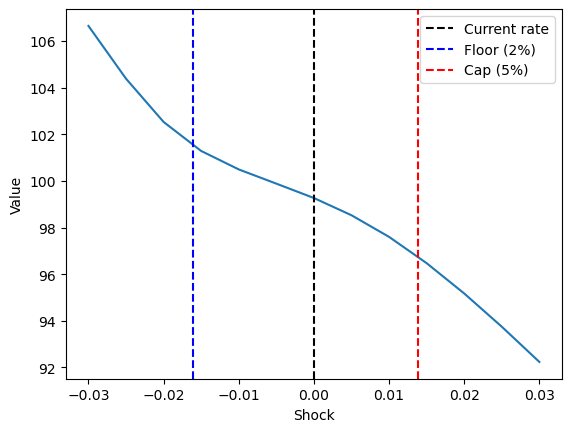

In [42]:
# Claude Sonnet 4.6: add lines to my graph
shocks = [-0.03, -0.025, -0.02, -0.015, -0.01, -0.005, 0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03]
port_values = []
for shock in shocks:
    shocked_spots     = curves['spot rates'] + shock
    shocked_discounts = (1 + shocked_spots / FREQ_CURVE) ** (-FREQ_CURVE * curves.index)
    shocked_discounts = pd.Series(shocked_discounts.values, index=curves.index)
    shocked_forwards  = (shocked_discounts.shift(1) / shocked_discounts - 1) / tau

    cap_shocked = floor_shocked = 0.0
    for tenor, row in curves.iterrows():
        t_reset = tenor - tau
        F       = shocked_forwards[tenor]
        df_pay  = shocked_discounts[tenor]
        cap_shocked   += black76(F, BOUND_UPPER, sigma, t_reset, df_pay, tau, NOTIONAL, 'cap')
        floor_shocked += black76(F, BOUND_LOWER, sigma, t_reset, df_pay, tau, NOTIONAL, 'floor')
    port_values.append(100 + floor_shocked - cap_shocked)

plt.plot(shocks, port_values)
plt.xlabel('Shock')
plt.ylabel('Value')
current_rate = curves.loc[5.0, 'spot rates']
plt.axvline(x=0,                  color='black', linestyle='--', label='Current rate')
plt.axvline(x=BOUND_LOWER - current_rate, color='blue',  linestyle='--', label='Floor (2%)')
plt.axvline(x=BOUND_UPPER - current_rate, color='red',   linestyle='--', label='Cap (5%)')
plt.legend()

In [41]:
print('''There is convexity when the shock is negative (profit) but becomes slightly concave
when the shock is positive (loss). You can see that the profit is nearly linear within the strike bounds.''')

There is convexity when the shock is negative (profit) but becomes slightly concave
when the shock is positive (loss)


# 3. Stress Test: A +300bp Shock


In 1994, the Federal Reserve raised rates roughly 300bp in under a year, causing large losses on structured note portfolios — most notably Orange County's $1.7 billion loss.

Orange County held primarily **inverse floaters** (coupon = Fixed Rate $-$ Multiplier $\times$ Floating Rate), which are more aggressive than a collared floater. But it is instructive to see what a +300bp shock does to our product.


### 3.1.

Compute the portfolio value after a +300bp parallel shock to the spot curve.

Report the percentage loss.

In [46]:
shocked_spots     = curves['spot rates'] + 0.03
shocked_discounts = (1 + shocked_spots / FREQ_CURVE) ** (-FREQ_CURVE * curves.index)
shocked_discounts = pd.Series(shocked_discounts.values, index=curves.index)
shocked_forwards  = (shocked_discounts.shift(1) / shocked_discounts - 1) / tau

cap_shocked = floor_shocked = 0.0
for tenor, row in curves.iterrows():
    t_reset = tenor - tau
    F       = shocked_forwards[tenor]
    df_pay  = shocked_discounts[tenor]
    cap_shocked   += black76(F, BOUND_UPPER, sigma, t_reset, df_pay, tau, NOTIONAL, 'cap')
    floor_shocked += black76(F, BOUND_LOWER, sigma, t_reset, df_pay, tau, NOTIONAL, 'floor')

new_val = 100 + floor_shocked - cap_shocked
print(f'Portfolio Change: {(new_val - port) / port * 100:.3f}%')

Portfolio Change: -7.083%


### 3.2.

Orange County's investment pool was leveraged roughly 2.5x.

If we apply the same leverage to the loss from 3.1, what is the leveraged loss?

How does it compare to Orange County's actual 22.3% loss? Why is the gap so large?


In [48]:
print('''The leveraged loss would be approximately 17.7%.
The gap is likely due to the use of negative duration of their portfolio, creating negative convexity,
as well as the lack of a rate call, which our portfolio has. In addition, we assume no forced exit, which
was not the case historically, realizing losses at the worst instance.''')

The leveraged loss would be approximately 17.7%.
The gap is likely due to the use of negative duration of their portfolio, creating negative convexity,
as well as the lack of a rate call, which our portfolio has. In addition, we assume no forced exit, which
was not the case historically, realizing losses at the worst instance.


# 4. Optional: Volatility Skew

*Requires SABR (Chapter 8).*

### 4.1.

The analysis above uses a single flat vol for both the cap and floor. In practice, implied volatility varies with strike.

Using the SABR parameters below (estimated in `E.8.2. SABR Calibration`), compute the SABR-implied vol at each strike (2% and 5%).

| Parameter | Value |
|-----------|-------|
| beta | 0.25 |
| alpha | 0.0214 |
| nu | 0.60 |
| rho | -0.20 |

Use the 5-year forward rate as the forward.


### 4.2.

Re-price the floor and cap using the SABR-implied vols (one vol per instrument).

Compare the flat-vol portfolio value to the SABR-adjusted portfolio value. Which direction does the skew push the price, and why?


Part 2 (C.9.1) values the same product using binomial trees.